<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:54:45] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


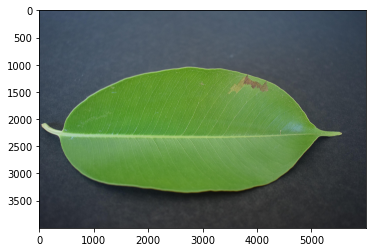

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

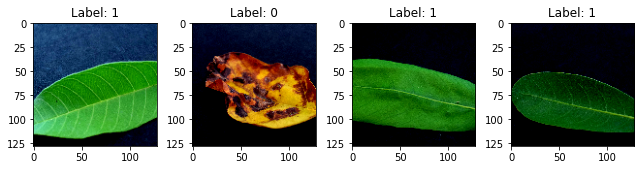

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:54:51] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:54:53] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2434678201163925 samples/sec                   batch loss = 0.4598492681980133 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.2634395265547818 samples/sec                   batch loss = 0.6410722732543945 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2647187218703213 samples/sec                   batch loss = 0.21943353116512299 | accuracy = 0.6666666666666666


Epoch[1] Batch[20] Speed: 1.2642824131062884 samples/sec                   batch loss = 1.744118571281433 | accuracy = 0.65


Epoch[1] Batch[25] Speed: 1.2664468963845095 samples/sec                   batch loss = 1.7860791683197021 | accuracy = 0.64


Epoch[1] Batch[30] Speed: 1.2647587652790382 samples/sec                   batch loss = 1.0755606889724731 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.2530693155679664 samples/sec                   batch loss = 0.6778650283813477 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.2718033153485058 samples/sec                   batch loss = 0.44121959805488586 | accuracy = 0.6125


Epoch[1] Batch[45] Speed: 1.2675322069312425 samples/sec                   batch loss = 0.6087470054626465 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2676080558299474 samples/sec                   batch loss = 0.45916953682899475 | accuracy = 0.62


Epoch[1] Batch[55] Speed: 1.2720074471032312 samples/sec                   batch loss = 0.6115343570709229 | accuracy = 0.6227272727272727


Epoch[1] Batch[60] Speed: 1.2700668470339738 samples/sec                   batch loss = 0.8215466141700745 | accuracy = 0.6208333333333333


Epoch[1] Batch[65] Speed: 1.2672632655119163 samples/sec                   batch loss = 0.21228335797786713 | accuracy = 0.6346153846153846


Epoch[1] Batch[70] Speed: 1.2696300117085668 samples/sec                   batch loss = 0.6503442525863647 | accuracy = 0.6428571428571429


Epoch[1] Batch[75] Speed: 1.2676663852101195 samples/sec                   batch loss = 1.0612576007843018 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.2628370661579755 samples/sec                   batch loss = 0.9713109135627747 | accuracy = 0.646875


Epoch[1] Batch[85] Speed: 1.2652142944675395 samples/sec                   batch loss = 0.2855466902256012 | accuracy = 0.6529411764705882


Epoch[1] Batch[90] Speed: 1.2671160614881356 samples/sec                   batch loss = 0.47935256361961365 | accuracy = 0.6472222222222223


Epoch[1] Batch[95] Speed: 1.2688122226706908 samples/sec                   batch loss = 0.3180287182331085 | accuracy = 0.6526315789473685


Epoch[1] Batch[100] Speed: 1.2708120344206335 samples/sec                   batch loss = 0.8614928722381592 | accuracy = 0.6475


Epoch[1] Batch[105] Speed: 1.2722314213531933 samples/sec                   batch loss = 0.44761860370635986 | accuracy = 0.6523809523809524


Epoch[1] Batch[110] Speed: 1.2676359268345407 samples/sec                   batch loss = 0.2637210488319397 | accuracy = 0.6613636363636364


Epoch[1] Batch[115] Speed: 1.2702573417233696 samples/sec                   batch loss = 0.7042667269706726 | accuracy = 0.658695652173913


Epoch[1] Batch[120] Speed: 1.2719254779685358 samples/sec                   batch loss = 0.7161474227905273 | accuracy = 0.6583333333333333


Epoch[1] Batch[125] Speed: 1.271635295720942 samples/sec                   batch loss = 0.4609087109565735 | accuracy = 0.654


Epoch[1] Batch[130] Speed: 1.2725110657812322 samples/sec                   batch loss = 0.4930964410305023 | accuracy = 0.6576923076923077


Epoch[1] Batch[135] Speed: 1.2730585518961401 samples/sec                   batch loss = 0.5421165227890015 | accuracy = 0.6648148148148149


Epoch[1] Batch[140] Speed: 1.267144197974967 samples/sec                   batch loss = 0.5314756035804749 | accuracy = 0.6642857142857143


Epoch[1] Batch[145] Speed: 1.262801231458091 samples/sec                   batch loss = 0.24667473137378693 | accuracy = 0.6637931034482759


Epoch[1] Batch[150] Speed: 1.2636268009858227 samples/sec                   batch loss = 0.39012572169303894 | accuracy = 0.6633333333333333


Epoch[1] Batch[155] Speed: 1.2647786925868203 samples/sec                   batch loss = 0.3879227340221405 | accuracy = 0.667741935483871


Epoch[1] Batch[160] Speed: 1.2669969259275873 samples/sec                   batch loss = 0.7490666508674622 | accuracy = 0.6671875


Epoch[1] Batch[165] Speed: 1.2682081757668395 samples/sec                   batch loss = 0.9370609521865845 | accuracy = 0.6681818181818182


Epoch[1] Batch[170] Speed: 1.2670593138044928 samples/sec                   batch loss = 0.5026224255561829 | accuracy = 0.6647058823529411


Epoch[1] Batch[175] Speed: 1.2676115037228477 samples/sec                   batch loss = 0.7038489580154419 | accuracy = 0.67


Epoch[1] Batch[180] Speed: 1.2695445059782162 samples/sec                   batch loss = 0.43296730518341064 | accuracy = 0.6736111111111112


Epoch[1] Batch[185] Speed: 1.2665612433021727 samples/sec                   batch loss = 0.688218891620636 | accuracy = 0.6743243243243243


Epoch[1] Batch[190] Speed: 1.2677777910437114 samples/sec                   batch loss = 0.11266028136014938 | accuracy = 0.6776315789473685


Epoch[1] Batch[195] Speed: 1.2669995093526951 samples/sec                   batch loss = 0.20885233581066132 | accuracy = 0.6756410256410257


Epoch[1] Batch[200] Speed: 1.2683413465790907 samples/sec                   batch loss = 1.5722240209579468 | accuracy = 0.67625


Epoch[1] Batch[205] Speed: 1.2646284428212438 samples/sec                   batch loss = 0.47259169816970825 | accuracy = 0.6743902439024391


Epoch[1] Batch[210] Speed: 1.2666506509686652 samples/sec                   batch loss = 0.37744465470314026 | accuracy = 0.6726190476190477


Epoch[1] Batch[215] Speed: 1.2675212900340278 samples/sec                   batch loss = 0.5853915810585022 | accuracy = 0.6732558139534883


Epoch[1] Batch[220] Speed: 1.26763707618063 samples/sec                   batch loss = 0.4160376787185669 | accuracy = 0.675


Epoch[1] Batch[225] Speed: 1.2776756153070834 samples/sec                   batch loss = 0.4732230305671692 | accuracy = 0.6722222222222223


Epoch[1] Batch[230] Speed: 1.2719232601269814 samples/sec                   batch loss = 0.3482370972633362 | accuracy = 0.6706521739130434


Epoch[1] Batch[235] Speed: 1.2721975597203643 samples/sec                   batch loss = 0.6915135979652405 | accuracy = 0.6680851063829787


Epoch[1] Batch[240] Speed: 1.276497598028724 samples/sec                   batch loss = 0.7016898393630981 | accuracy = 0.66875


Epoch[1] Batch[245] Speed: 1.27331063104681 samples/sec                   batch loss = 0.35711339116096497 | accuracy = 0.6673469387755102


Epoch[1] Batch[250] Speed: 1.269906687243881 samples/sec                   batch loss = 1.669822096824646 | accuracy = 0.666


Epoch[1] Batch[255] Speed: 1.2639157197465511 samples/sec                   batch loss = 0.491142213344574 | accuracy = 0.6686274509803921


Epoch[1] Batch[260] Speed: 1.269213063988561 samples/sec                   batch loss = 0.41056379675865173 | accuracy = 0.6701923076923076


Epoch[1] Batch[265] Speed: 1.2718721554858665 samples/sec                   batch loss = 0.7508301138877869 | accuracy = 0.6688679245283019


Epoch[1] Batch[270] Speed: 1.2630335753169213 samples/sec                   batch loss = 0.43364185094833374 | accuracy = 0.6703703703703704


Epoch[1] Batch[275] Speed: 1.2679459426819029 samples/sec                   batch loss = 0.369994580745697 | accuracy = 0.6718181818181819


Epoch[1] Batch[280] Speed: 1.2768300379741122 samples/sec                   batch loss = 0.6419703960418701 | accuracy = 0.6732142857142858


Epoch[1] Batch[285] Speed: 1.2680045906662247 samples/sec                   batch loss = 1.266621470451355 | accuracy = 0.6719298245614035


Epoch[1] Batch[290] Speed: 1.2756695829449802 samples/sec                   batch loss = 0.38527199625968933 | accuracy = 0.6706896551724137


Epoch[1] Batch[295] Speed: 1.2760494377035088 samples/sec                   batch loss = 0.6082374453544617 | accuracy = 0.6711864406779661


Epoch[1] Batch[300] Speed: 1.2748676345465 samples/sec                   batch loss = 1.115463376045227 | accuracy = 0.6725


Epoch[1] Batch[305] Speed: 1.2700414648778668 samples/sec                   batch loss = 0.709668755531311 | accuracy = 0.6721311475409836


Epoch[1] Batch[310] Speed: 1.2691231982249298 samples/sec                   batch loss = 0.7724260091781616 | accuracy = 0.6725806451612903


Epoch[1] Batch[315] Speed: 1.2672048775090081 samples/sec                   batch loss = 0.510167121887207 | accuracy = 0.6738095238095239


Epoch[1] Batch[320] Speed: 1.2619038414123875 samples/sec                   batch loss = 0.2996571958065033 | accuracy = 0.675


Epoch[1] Batch[325] Speed: 1.266049042110436 samples/sec                   batch loss = 0.2887786030769348 | accuracy = 0.6761538461538461


Epoch[1] Batch[330] Speed: 1.2648506840260922 samples/sec                   batch loss = 1.854853630065918 | accuracy = 0.6742424242424242


Epoch[1] Batch[335] Speed: 1.261966962721493 samples/sec                   batch loss = 0.48749738931655884 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.2736251694305047 samples/sec                   batch loss = 0.6146470904350281 | accuracy = 0.675


Epoch[1] Batch[345] Speed: 1.276367661275236 samples/sec                   batch loss = 0.3953534662723541 | accuracy = 0.6760869565217391


Epoch[1] Batch[350] Speed: 1.267645696342734 samples/sec                   batch loss = 0.6683568954467773 | accuracy = 0.6757142857142857


Epoch[1] Batch[355] Speed: 1.2709814733937843 samples/sec                   batch loss = 0.8138386607170105 | accuracy = 0.6774647887323944


Epoch[1] Batch[360] Speed: 1.2719979960053545 samples/sec                   batch loss = 0.2548414170742035 | accuracy = 0.6791666666666667


Epoch[1] Batch[365] Speed: 1.267351814963125 samples/sec                   batch loss = 1.0142838954925537 | accuracy = 0.6794520547945205


Epoch[1] Batch[370] Speed: 1.2654896213385791 samples/sec                   batch loss = 0.4269823133945465 | accuracy = 0.6790540540540541


Epoch[1] Batch[375] Speed: 1.2665856259594392 samples/sec                   batch loss = 0.4923575818538666 | accuracy = 0.6786666666666666


Epoch[1] Batch[380] Speed: 1.273012861763904 samples/sec                   batch loss = 0.8356645107269287 | accuracy = 0.6776315789473685


Epoch[1] Batch[385] Speed: 1.2680146533656713 samples/sec                   batch loss = 1.6577330827713013 | accuracy = 0.6766233766233766


Epoch[1] Batch[390] Speed: 1.2725916624739266 samples/sec                   batch loss = 0.32653576135635376 | accuracy = 0.6788461538461539


Epoch[1] Batch[395] Speed: 1.2724590453138092 samples/sec                   batch loss = 0.4459661543369293 | accuracy = 0.6778481012658227


Epoch[1] Batch[400] Speed: 1.2709665493971376 samples/sec                   batch loss = 0.2476370483636856 | accuracy = 0.6775


Epoch[1] Batch[405] Speed: 1.2712728022198683 samples/sec                   batch loss = 1.1088837385177612 | accuracy = 0.6777777777777778


Epoch[1] Batch[410] Speed: 1.2732732331616583 samples/sec                   batch loss = 0.46156156063079834 | accuracy = 0.676829268292683


Epoch[1] Batch[415] Speed: 1.2687235649758157 samples/sec                   batch loss = 0.8759205937385559 | accuracy = 0.677710843373494


Epoch[1] Batch[420] Speed: 1.2712114435288806 samples/sec                   batch loss = 0.8922685980796814 | accuracy = 0.6767857142857143


Epoch[1] Batch[425] Speed: 1.2663381138862373 samples/sec                   batch loss = 0.29909977316856384 | accuracy = 0.6764705882352942


Epoch[1] Batch[430] Speed: 1.2644255288425414 samples/sec                   batch loss = 0.4999563694000244 | accuracy = 0.6767441860465117


Epoch[1] Batch[435] Speed: 1.271102129926679 samples/sec                   batch loss = 0.6721258163452148 | accuracy = 0.674712643678161


Epoch[1] Batch[440] Speed: 1.2691332786864908 samples/sec                   batch loss = 0.4135942757129669 | accuracy = 0.675


Epoch[1] Batch[445] Speed: 1.2712206902994843 samples/sec                   batch loss = 0.5787190198898315 | accuracy = 0.6764044943820224


Epoch[1] Batch[450] Speed: 1.2716318259039672 samples/sec                   batch loss = 0.48587170243263245 | accuracy = 0.6777777777777778


Epoch[1] Batch[455] Speed: 1.2679882031832541 samples/sec                   batch loss = 0.5701687335968018 | accuracy = 0.6796703296703297


Epoch[1] Batch[460] Speed: 1.272746031225838 samples/sec                   batch loss = 0.7547742128372192 | accuracy = 0.6804347826086956


Epoch[1] Batch[465] Speed: 1.271018351611105 samples/sec                   batch loss = 0.5656959414482117 | accuracy = 0.6801075268817204


Epoch[1] Batch[470] Speed: 1.272079781584507 samples/sec                   batch loss = 1.2349586486816406 | accuracy = 0.6792553191489362


Epoch[1] Batch[475] Speed: 1.273341556022019 samples/sec                   batch loss = 0.31083396077156067 | accuracy = 0.6794736842105263


Epoch[1] Batch[480] Speed: 1.2734447790005534 samples/sec                   batch loss = 0.7387967109680176 | accuracy = 0.6807291666666667


Epoch[1] Batch[485] Speed: 1.271151728041737 samples/sec                   batch loss = 0.5101374983787537 | accuracy = 0.6814432989690722


Epoch[1] Batch[490] Speed: 1.270923897584109 samples/sec                   batch loss = 0.5921905636787415 | accuracy = 0.6816326530612244


Epoch[1] Batch[495] Speed: 1.2720040716950098 samples/sec                   batch loss = 0.3917166590690613 | accuracy = 0.6823232323232323


Epoch[1] Batch[500] Speed: 1.2700716543747792 samples/sec                   batch loss = 0.9632264375686646 | accuracy = 0.6835


Epoch[1] Batch[505] Speed: 1.2720028179765188 samples/sec                   batch loss = 0.5649058222770691 | accuracy = 0.6841584158415842


Epoch[1] Batch[510] Speed: 1.2709440196403283 samples/sec                   batch loss = 0.6641553044319153 | accuracy = 0.682843137254902


Epoch[1] Batch[515] Speed: 1.2761393163824073 samples/sec                   batch loss = 0.5344628691673279 | accuracy = 0.6844660194174758


Epoch[1] Batch[520] Speed: 1.2724415774280249 samples/sec                   batch loss = 0.409074604511261 | accuracy = 0.6850961538461539


Epoch[1] Batch[525] Speed: 1.2706648709803632 samples/sec                   batch loss = 0.6320492625236511 | accuracy = 0.6842857142857143


Epoch[1] Batch[530] Speed: 1.2678813595122487 samples/sec                   batch loss = 0.444449245929718 | accuracy = 0.6849056603773584


Epoch[1] Batch[535] Speed: 1.2695013731882674 samples/sec                   batch loss = 0.5772716403007507 | accuracy = 0.6855140186915888


Epoch[1] Batch[540] Speed: 1.2693606596323237 samples/sec                   batch loss = 0.3600955605506897 | accuracy = 0.6865740740740741


Epoch[1] Batch[545] Speed: 1.2733822439807525 samples/sec                   batch loss = 0.35280439257621765 | accuracy = 0.6862385321100918


Epoch[1] Batch[550] Speed: 1.2656721570345706 samples/sec                   batch loss = 0.5263633131980896 | accuracy = 0.6859090909090909


Epoch[1] Batch[555] Speed: 1.2655589252399757 samples/sec                   batch loss = 0.6320841908454895 | accuracy = 0.6869369369369369


Epoch[1] Batch[560] Speed: 1.276273478523516 samples/sec                   batch loss = 0.7016604542732239 | accuracy = 0.6857142857142857


Epoch[1] Batch[565] Speed: 1.2716712479946821 samples/sec                   batch loss = 0.2524375319480896 | accuracy = 0.6867256637168142


Epoch[1] Batch[570] Speed: 1.2700486756145013 samples/sec                   batch loss = 0.35792115330696106 | accuracy = 0.6868421052631579


Epoch[1] Batch[575] Speed: 1.2739356069795615 samples/sec                   batch loss = 0.7353104948997498 | accuracy = 0.6852173913043478


Epoch[1] Batch[580] Speed: 1.2689475358932358 samples/sec                   batch loss = 1.0730531215667725 | accuracy = 0.6844827586206896


Epoch[1] Batch[585] Speed: 1.2680529889219685 samples/sec                   batch loss = 0.39877164363861084 | accuracy = 0.6846153846153846


Epoch[1] Batch[590] Speed: 1.2715272583604476 samples/sec                   batch loss = 0.5190266966819763 | accuracy = 0.6834745762711865


Epoch[1] Batch[595] Speed: 1.270888757722044 samples/sec                   batch loss = 0.941264808177948 | accuracy = 0.6848739495798319


Epoch[1] Batch[600] Speed: 1.273252264249302 samples/sec                   batch loss = 0.5146517157554626 | accuracy = 0.685


Epoch[1] Batch[605] Speed: 1.2713789657805903 samples/sec                   batch loss = 0.0918145552277565 | accuracy = 0.6871900826446281


Epoch[1] Batch[610] Speed: 1.2738491334680133 samples/sec                   batch loss = 0.5003932118415833 | accuracy = 0.6877049180327869


Epoch[1] Batch[615] Speed: 1.2692824882428142 samples/sec                   batch loss = 0.3516273498535156 | accuracy = 0.6878048780487804


Epoch[1] Batch[620] Speed: 1.2747048090026416 samples/sec                   batch loss = 0.32985377311706543 | accuracy = 0.6883064516129033


Epoch[1] Batch[625] Speed: 1.2683380864844693 samples/sec                   batch loss = 0.25134265422821045 | accuracy = 0.69


Epoch[1] Batch[630] Speed: 1.2676227095043129 samples/sec                   batch loss = 0.3203149139881134 | accuracy = 0.6900793650793651


Epoch[1] Batch[635] Speed: 1.269523947890939 samples/sec                   batch loss = 0.3976707458496094 | accuracy = 0.6905511811023622


Epoch[1] Batch[640] Speed: 1.2671742498884997 samples/sec                   batch loss = 0.8801073431968689 | accuracy = 0.6921875


Epoch[1] Batch[645] Speed: 1.2659779650079352 samples/sec                   batch loss = 0.4014877676963806 | accuracy = 0.6922480620155039


Epoch[1] Batch[650] Speed: 1.2677708934673575 samples/sec                   batch loss = 0.4239887297153473 | accuracy = 0.6938461538461539


Epoch[1] Batch[655] Speed: 1.2689317958508122 samples/sec                   batch loss = 0.8018501400947571 | accuracy = 0.6931297709923664


Epoch[1] Batch[660] Speed: 1.2666720724336535 samples/sec                   batch loss = 0.25360357761383057 | accuracy = 0.6943181818181818


Epoch[1] Batch[665] Speed: 1.2645697254584147 samples/sec                   batch loss = 0.5891861915588379 | accuracy = 0.6943609022556391


Epoch[1] Batch[670] Speed: 1.2651272836490153 samples/sec                   batch loss = 0.28984636068344116 | accuracy = 0.6936567164179105


Epoch[1] Batch[675] Speed: 1.2685558784600444 samples/sec                   batch loss = 0.29356634616851807 | accuracy = 0.6940740740740741


Epoch[1] Batch[680] Speed: 1.2705434314727209 samples/sec                   batch loss = 0.7440894842147827 | accuracy = 0.6933823529411764


Epoch[1] Batch[685] Speed: 1.2643758824969282 samples/sec                   batch loss = 0.25463539361953735 | accuracy = 0.6930656934306569


Epoch[1] Batch[690] Speed: 1.264694792376982 samples/sec                   batch loss = 0.4766635596752167 | accuracy = 0.6934782608695652


Epoch[1] Batch[695] Speed: 1.2703408273668644 samples/sec                   batch loss = 0.5528049468994141 | accuracy = 0.6931654676258993


Epoch[1] Batch[700] Speed: 1.267524354407244 samples/sec                   batch loss = 0.4841548204421997 | accuracy = 0.6942857142857143


Epoch[1] Batch[705] Speed: 1.273991424417523 samples/sec                   batch loss = 0.344829261302948 | accuracy = 0.6950354609929078


Epoch[1] Batch[710] Speed: 1.2648359036580932 samples/sec                   batch loss = 0.8099655508995056 | accuracy = 0.6950704225352112


Epoch[1] Batch[715] Speed: 1.2731900379948649 samples/sec                   batch loss = 0.23139967024326324 | accuracy = 0.6961538461538461


Epoch[1] Batch[720] Speed: 1.2698874630939214 samples/sec                   batch loss = 0.40973764657974243 | accuracy = 0.696875


Epoch[1] Batch[725] Speed: 1.2669343528485681 samples/sec                   batch loss = 0.5777683854103088 | accuracy = 0.6979310344827586


Epoch[1] Batch[730] Speed: 1.2677212714498065 samples/sec                   batch loss = 0.4385051131248474 | accuracy = 0.6972602739726027


Epoch[1] Batch[735] Speed: 1.266563346866974 samples/sec                   batch loss = 0.3368678689002991 | accuracy = 0.6972789115646258


Epoch[1] Batch[740] Speed: 1.2683061576200694 samples/sec                   batch loss = 0.22141088545322418 | accuracy = 0.697972972972973


Epoch[1] Batch[745] Speed: 1.2691886760808484 samples/sec                   batch loss = 0.5945941209793091 | accuracy = 0.697986577181208


Epoch[1] Batch[750] Speed: 1.2686106499010879 samples/sec                   batch loss = 0.39832764863967896 | accuracy = 0.698


Epoch[1] Batch[755] Speed: 1.2633238400152769 samples/sec                   batch loss = 0.27519261837005615 | accuracy = 0.6993377483443709


Epoch[1] Batch[760] Speed: 1.2680717741907446 samples/sec                   batch loss = 0.3342858850955963 | accuracy = 0.6996710526315789


Epoch[1] Batch[765] Speed: 1.2668307477165135 samples/sec                   batch loss = 0.8111002445220947 | accuracy = 0.6993464052287581


Epoch[1] Batch[770] Speed: 1.26514044899126 samples/sec                   batch loss = 0.9072989225387573 | accuracy = 0.6983766233766234


Epoch[1] Batch[775] Speed: 1.2716295127031705 samples/sec                   batch loss = 0.7295449376106262 | accuracy = 0.6993548387096774


Epoch[1] Batch[780] Speed: 1.2621616819056478 samples/sec                   batch loss = 0.7208886742591858 | accuracy = 0.6993589743589743


Epoch[1] Batch[785] Speed: 1.2632933997101623 samples/sec                   batch loss = 0.5587122440338135 | accuracy = 0.7


[Epoch 1] training: accuracy=0.700507614213198
[Epoch 1] time cost: 653.3455138206482
[Epoch 1] validation: validation accuracy=0.7333333333333333


Epoch[2] Batch[5] Speed: 1.2715054796352947 samples/sec                   batch loss = 0.3164626657962799 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2758646729354617 samples/sec                   batch loss = 0.504797101020813 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.277530068248026 samples/sec                   batch loss = 0.8186755180358887 | accuracy = 0.6666666666666666


Epoch[2] Batch[20] Speed: 1.2692410056175125 samples/sec                   batch loss = 0.5743752121925354 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.2738862750145121 samples/sec                   batch loss = 0.6136252284049988 | accuracy = 0.7


Epoch[2] Batch[30] Speed: 1.2707930716196332 samples/sec                   batch loss = 0.20468981564044952 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2718476652832964 samples/sec                   batch loss = 0.36856839060783386 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2742650683303218 samples/sec                   batch loss = 0.7811920046806335 | accuracy = 0.70625


Epoch[2] Batch[45] Speed: 1.272132735640087 samples/sec                   batch loss = 0.22338633239269257 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2712343680609905 samples/sec                   batch loss = 0.36880865693092346 | accuracy = 0.705


Epoch[2] Batch[55] Speed: 1.2688939829545192 samples/sec                   batch loss = 0.648798942565918 | accuracy = 0.7090909090909091


Epoch[2] Batch[60] Speed: 1.2738987527388053 samples/sec                   batch loss = 0.38889169692993164 | accuracy = 0.7125


Epoch[2] Batch[65] Speed: 1.267945367728519 samples/sec                   batch loss = 0.6294171810150146 | accuracy = 0.7038461538461539


Epoch[2] Batch[70] Speed: 1.2740241239061165 samples/sec                   batch loss = 0.5842354893684387 | accuracy = 0.7035714285714286


Epoch[2] Batch[75] Speed: 1.269606664618916 samples/sec                   batch loss = 0.6809071898460388 | accuracy = 0.6933333333333334


Epoch[2] Batch[80] Speed: 1.2759049401076927 samples/sec                   batch loss = 0.7930852770805359 | accuracy = 0.703125


Epoch[2] Batch[85] Speed: 1.2783812489632382 samples/sec                   batch loss = 0.1776420772075653 | accuracy = 0.7058823529411765


Epoch[2] Batch[90] Speed: 1.2665826617431357 samples/sec                   batch loss = 0.5631404519081116 | accuracy = 0.7111111111111111


Epoch[2] Batch[95] Speed: 1.267573577932521 samples/sec                   batch loss = 0.4326784014701843 | accuracy = 0.7157894736842105


Epoch[2] Batch[100] Speed: 1.269844210884522 samples/sec                   batch loss = 0.5656042695045471 | accuracy = 0.72


Epoch[2] Batch[105] Speed: 1.2692782630365842 samples/sec                   batch loss = 0.6022678017616272 | accuracy = 0.7214285714285714


Epoch[2] Batch[110] Speed: 1.272151159669483 samples/sec                   batch loss = 0.3049754202365875 | accuracy = 0.725


Epoch[2] Batch[115] Speed: 1.2713470763144732 samples/sec                   batch loss = 0.3065715432167053 | accuracy = 0.7304347826086957


Epoch[2] Batch[120] Speed: 1.2665773070649824 samples/sec                   batch loss = 0.3779061436653137 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.265335671651393 samples/sec                   batch loss = 0.3002408444881439 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.2663506353485487 samples/sec                   batch loss = 0.2594982087612152 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.2772054310183583 samples/sec                   batch loss = 0.22757713496685028 | accuracy = 0.7444444444444445


Epoch[2] Batch[140] Speed: 1.2699523469328589 samples/sec                   batch loss = 0.5727351307868958 | accuracy = 0.7446428571428572


Epoch[2] Batch[145] Speed: 1.275161329355102 samples/sec                   batch loss = 0.23191116750240326 | accuracy = 0.7396551724137931


Epoch[2] Batch[150] Speed: 1.2690926698039184 samples/sec                   batch loss = 0.15393759310245514 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.268932947547993 samples/sec                   batch loss = 0.4733455181121826 | accuracy = 0.75


Epoch[2] Batch[160] Speed: 1.2704211493736912 samples/sec                   batch loss = 0.11223305016756058 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2620934141718696 samples/sec                   batch loss = 0.29799896478652954 | accuracy = 0.7545454545454545


Epoch[2] Batch[170] Speed: 1.268455460450133 samples/sec                   batch loss = 0.46912530064582825 | accuracy = 0.75


Epoch[2] Batch[175] Speed: 1.2695061762492579 samples/sec                   batch loss = 0.7716094851493835 | accuracy = 0.75


Epoch[2] Batch[180] Speed: 1.2690999657709756 samples/sec                   batch loss = 0.40200433135032654 | accuracy = 0.7513888888888889


Epoch[2] Batch[185] Speed: 1.2667455229574944 samples/sec                   batch loss = 0.8566499948501587 | accuracy = 0.7486486486486487


Epoch[2] Batch[190] Speed: 1.2658592343721364 samples/sec                   batch loss = 0.3690968453884125 | accuracy = 0.7526315789473684


Epoch[2] Batch[195] Speed: 1.2688178841348303 samples/sec                   batch loss = 0.13546665012836456 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2712427482433784 samples/sec                   batch loss = 0.3012491464614868 | accuracy = 0.75125


Epoch[2] Batch[205] Speed: 1.2699584030961244 samples/sec                   batch loss = 0.5215169191360474 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.268600865513858 samples/sec                   batch loss = 1.0580031871795654 | accuracy = 0.7452380952380953


Epoch[2] Batch[215] Speed: 1.2709884059501522 samples/sec                   batch loss = 0.44206520915031433 | accuracy = 0.7465116279069768


Epoch[2] Batch[220] Speed: 1.2702558990955686 samples/sec                   batch loss = 0.5490496158599854 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.2632823654618215 samples/sec                   batch loss = 0.17684444785118103 | accuracy = 0.7477777777777778


Epoch[2] Batch[230] Speed: 1.261441587292183 samples/sec                   batch loss = 1.185879111289978 | accuracy = 0.7434782608695653


Epoch[2] Batch[235] Speed: 1.262342498898841 samples/sec                   batch loss = 0.3996265232563019 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.2712021968927967 samples/sec                   batch loss = 1.0256620645523071 | accuracy = 0.7447916666666666


Epoch[2] Batch[245] Speed: 1.269001477293244 samples/sec                   batch loss = 0.6087464094161987 | accuracy = 0.7459183673469387


Epoch[2] Batch[250] Speed: 1.271600502024477 samples/sec                   batch loss = 0.3083871006965637 | accuracy = 0.748


Epoch[2] Batch[255] Speed: 1.2718697449910112 samples/sec                   batch loss = 0.20437392592430115 | accuracy = 0.7490196078431373


Epoch[2] Batch[260] Speed: 1.277747525457518 samples/sec                   batch loss = 0.6388627290725708 | accuracy = 0.7490384615384615


Epoch[2] Batch[265] Speed: 1.2711897719373828 samples/sec                   batch loss = 0.2533497214317322 | accuracy = 0.7509433962264151


Epoch[2] Batch[270] Speed: 1.2744585671842652 samples/sec                   batch loss = 0.11778944730758667 | accuracy = 0.7537037037037037


Epoch[2] Batch[275] Speed: 1.2754031889306432 samples/sec                   batch loss = 0.5160475373268127 | accuracy = 0.7563636363636363


Epoch[2] Batch[280] Speed: 1.2718892220507894 samples/sec                   batch loss = 0.1974492073059082 | accuracy = 0.7580357142857143


Epoch[2] Batch[285] Speed: 1.2779737205611648 samples/sec                   batch loss = 0.6421385407447815 | accuracy = 0.7570175438596491


Epoch[2] Batch[290] Speed: 1.2740536322818874 samples/sec                   batch loss = 1.293447732925415 | accuracy = 0.7551724137931034


Epoch[2] Batch[295] Speed: 1.2730415505335673 samples/sec                   batch loss = 0.24161379039287567 | accuracy = 0.7559322033898305


Epoch[2] Batch[300] Speed: 1.268291200506796 samples/sec                   batch loss = 0.5240181684494019 | accuracy = 0.755


Epoch[2] Batch[305] Speed: 1.2715813229338415 samples/sec                   batch loss = 0.6347744464874268 | accuracy = 0.7516393442622951


Epoch[2] Batch[310] Speed: 1.2726189807952837 samples/sec                   batch loss = 0.325171560049057 | accuracy = 0.7524193548387097


Epoch[2] Batch[315] Speed: 1.2712391842442627 samples/sec                   batch loss = 0.3059536814689636 | accuracy = 0.7531746031746032


Epoch[2] Batch[320] Speed: 1.2715135742955817 samples/sec                   batch loss = 0.27406272292137146 | accuracy = 0.7546875


Epoch[2] Batch[325] Speed: 1.2698908272781482 samples/sec                   batch loss = 0.7469745874404907 | accuracy = 0.7553846153846154


Epoch[2] Batch[330] Speed: 1.2681253536015105 samples/sec                   batch loss = 0.6411559581756592 | accuracy = 0.7560606060606061


Epoch[2] Batch[335] Speed: 1.2662718785143365 samples/sec                   batch loss = 0.6400398015975952 | accuracy = 0.755223880597015


Epoch[2] Batch[340] Speed: 1.2720328114580801 samples/sec                   batch loss = 0.6875209808349609 | accuracy = 0.7544117647058823


Epoch[2] Batch[345] Speed: 1.2697517571535102 samples/sec                   batch loss = 0.476482093334198 | accuracy = 0.7536231884057971


Epoch[2] Batch[350] Speed: 1.266615173261016 samples/sec                   batch loss = 0.4417215585708618 | accuracy = 0.7557142857142857


Epoch[2] Batch[355] Speed: 1.2749562810451696 samples/sec                   batch loss = 0.504615306854248 | accuracy = 0.7535211267605634


Epoch[2] Batch[360] Speed: 1.2697730914349734 samples/sec                   batch loss = 0.3902898132801056 | accuracy = 0.7506944444444444


Epoch[2] Batch[365] Speed: 1.2679926114703597 samples/sec                   batch loss = 0.8289383053779602 | accuracy = 0.7506849315068493


Epoch[2] Batch[370] Speed: 1.2679653955786463 samples/sec                   batch loss = 0.2546599805355072 | accuracy = 0.7513513513513513


Epoch[2] Batch[375] Speed: 1.261567459152232 samples/sec                   batch loss = 0.558363139629364 | accuracy = 0.7533333333333333


Epoch[2] Batch[380] Speed: 1.2672362723565902 samples/sec                   batch loss = 0.6799443364143372 | accuracy = 0.7539473684210526


Epoch[2] Batch[385] Speed: 1.2665217549506345 samples/sec                   batch loss = 0.7010669112205505 | accuracy = 0.7538961038961038


Epoch[2] Batch[390] Speed: 1.269560549434093 samples/sec                   batch loss = 0.3201201558113098 | accuracy = 0.7532051282051282


Epoch[2] Batch[395] Speed: 1.2703173579435192 samples/sec                   batch loss = 0.27457499504089355 | accuracy = 0.7550632911392405


Epoch[2] Batch[400] Speed: 1.2743119130869245 samples/sec                   batch loss = 0.28051841259002686 | accuracy = 0.754375


Epoch[2] Batch[405] Speed: 1.264656373610428 samples/sec                   batch loss = 0.2971365451812744 | accuracy = 0.7555555555555555


Epoch[2] Batch[410] Speed: 1.2740684353590028 samples/sec                   batch loss = 0.5126457214355469 | accuracy = 0.7542682926829268


Epoch[2] Batch[415] Speed: 1.270008104268768 samples/sec                   batch loss = 0.1302255392074585 | accuracy = 0.7566265060240964


Epoch[2] Batch[420] Speed: 1.2708845218151181 samples/sec                   batch loss = 2.0430424213409424 | accuracy = 0.7553571428571428


Epoch[2] Batch[425] Speed: 1.2778024122636986 samples/sec                   batch loss = 0.3675639033317566 | accuracy = 0.7564705882352941


Epoch[2] Batch[430] Speed: 1.278398782896514 samples/sec                   batch loss = 0.48641812801361084 | accuracy = 0.7575581395348837


Epoch[2] Batch[435] Speed: 1.2658392730009775 samples/sec                   batch loss = 0.24881118535995483 | accuracy = 0.756896551724138


Epoch[2] Batch[440] Speed: 1.275324465443576 samples/sec                   batch loss = 0.3066609799861908 | accuracy = 0.7573863636363637


Epoch[2] Batch[445] Speed: 1.266159686061042 samples/sec                   batch loss = 0.4321231544017792 | accuracy = 0.7567415730337078


Epoch[2] Batch[450] Speed: 1.2782155770394388 samples/sec                   batch loss = 1.0750253200531006 | accuracy = 0.7572222222222222


Epoch[2] Batch[455] Speed: 1.2731541930224732 samples/sec                   batch loss = 0.4399474859237671 | accuracy = 0.7554945054945055


Epoch[2] Batch[460] Speed: 1.266775269017335 samples/sec                   batch loss = 0.2985990047454834 | accuracy = 0.7559782608695652


Epoch[2] Batch[465] Speed: 1.2703831514697925 samples/sec                   batch loss = 0.20017574727535248 | accuracy = 0.7564516129032258


Epoch[2] Batch[470] Speed: 1.263040611611844 samples/sec                   batch loss = 0.3400036096572876 | accuracy = 0.7558510638297873


Epoch[2] Batch[475] Speed: 1.2706169467536788 samples/sec                   batch loss = 0.5129433274269104 | accuracy = 0.7557894736842106


Epoch[2] Batch[480] Speed: 1.266454161962282 samples/sec                   batch loss = 0.6892392635345459 | accuracy = 0.7541666666666667


Epoch[2] Batch[485] Speed: 1.2657003249195056 samples/sec                   batch loss = 0.5205525755882263 | accuracy = 0.7536082474226804


Epoch[2] Batch[490] Speed: 1.2713044952920967 samples/sec                   batch loss = 0.2419108748435974 | accuracy = 0.7556122448979592


Epoch[2] Batch[495] Speed: 1.2673670371422068 samples/sec                   batch loss = 0.23988111317157745 | accuracy = 0.7545454545454545


Epoch[2] Batch[500] Speed: 1.2698469981603084 samples/sec                   batch loss = 0.5226742029190063 | accuracy = 0.7545


Epoch[2] Batch[505] Speed: 1.2670670648747053 samples/sec                   batch loss = 0.3984038233757019 | accuracy = 0.754950495049505


Epoch[2] Batch[510] Speed: 1.2721025445362848 samples/sec                   batch loss = 0.34330299496650696 | accuracy = 0.7553921568627451


Epoch[2] Batch[515] Speed: 1.2708211791208366 samples/sec                   batch loss = 0.34008073806762695 | accuracy = 0.7563106796116504


Epoch[2] Batch[520] Speed: 1.2696139664970616 samples/sec                   batch loss = 0.27186304330825806 | accuracy = 0.75625


Epoch[2] Batch[525] Speed: 1.2645815447489674 samples/sec                   batch loss = 0.31690219044685364 | accuracy = 0.7566666666666667


Epoch[2] Batch[530] Speed: 1.2732225997327156 samples/sec                   batch loss = 0.41342049837112427 | accuracy = 0.7575471698113208


Epoch[2] Batch[535] Speed: 1.2792494637774317 samples/sec                   batch loss = 0.6788125038146973 | accuracy = 0.7574766355140187


Epoch[2] Batch[540] Speed: 1.2659995547892229 samples/sec                   batch loss = 0.18229934573173523 | accuracy = 0.7583333333333333


Epoch[2] Batch[545] Speed: 1.268920470939887 samples/sec                   batch loss = 0.5056109428405762 | accuracy = 0.7582568807339449


Epoch[2] Batch[550] Speed: 1.277537169707933 samples/sec                   batch loss = 0.8580354452133179 | accuracy = 0.7581818181818182


Epoch[2] Batch[555] Speed: 1.273093811851192 samples/sec                   batch loss = 1.0903111696243286 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.2666395579947656 samples/sec                   batch loss = 0.2388961911201477 | accuracy = 0.759375


Epoch[2] Batch[565] Speed: 1.265650291981469 samples/sec                   batch loss = 1.1327470541000366 | accuracy = 0.7588495575221239


Epoch[2] Batch[570] Speed: 1.2651475087803967 samples/sec                   batch loss = 0.7461894750595093 | accuracy = 0.7583333333333333


Epoch[2] Batch[575] Speed: 1.2650114786042241 samples/sec                   batch loss = 0.26503774523735046 | accuracy = 0.7578260869565218


Epoch[2] Batch[580] Speed: 1.2713642251336765 samples/sec                   batch loss = 0.5310352444648743 | accuracy = 0.7577586206896552


Epoch[2] Batch[585] Speed: 1.2675612238090521 samples/sec                   batch loss = 1.074276328086853 | accuracy = 0.7568376068376068


Epoch[2] Batch[590] Speed: 1.2687452485054793 samples/sec                   batch loss = 0.30944594740867615 | accuracy = 0.7563559322033898


Epoch[2] Batch[595] Speed: 1.2748706376687546 samples/sec                   batch loss = 0.4759059250354767 | accuracy = 0.7571428571428571


Epoch[2] Batch[600] Speed: 1.2725135752248582 samples/sec                   batch loss = 1.0109738111495972 | accuracy = 0.7566666666666667


Epoch[2] Batch[605] Speed: 1.2671766426180378 samples/sec                   batch loss = 0.41515740752220154 | accuracy = 0.7574380165289256


Epoch[2] Batch[610] Speed: 1.2702860026082285 samples/sec                   batch loss = 0.5067020654678345 | accuracy = 0.7569672131147541


Epoch[2] Batch[615] Speed: 1.2686953583074883 samples/sec                   batch loss = 0.5978549718856812 | accuracy = 0.7569105691056911


Epoch[2] Batch[620] Speed: 1.263432295525337 samples/sec                   batch loss = 0.5058697462081909 | accuracy = 0.7568548387096774


Epoch[2] Batch[625] Speed: 1.2734724239499604 samples/sec                   batch loss = 0.4727875292301178 | accuracy = 0.7564


Epoch[2] Batch[630] Speed: 1.2714449656785516 samples/sec                   batch loss = 0.28100207448005676 | accuracy = 0.7563492063492063


Epoch[2] Batch[635] Speed: 1.2719392673308687 samples/sec                   batch loss = 0.19501179456710815 | accuracy = 0.7559055118110236


Epoch[2] Batch[640] Speed: 1.2697403215049783 samples/sec                   batch loss = 0.19615106284618378 | accuracy = 0.755859375


Epoch[2] Batch[645] Speed: 1.2712261806331788 samples/sec                   batch loss = 0.3061735928058624 | accuracy = 0.7565891472868217


Epoch[2] Batch[650] Speed: 1.2747521703825628 samples/sec                   batch loss = 0.40590471029281616 | accuracy = 0.7573076923076923


Epoch[2] Batch[655] Speed: 1.2746622932974079 samples/sec                   batch loss = 0.2774368226528168 | accuracy = 0.7580152671755725


Epoch[2] Batch[660] Speed: 1.2683550583370042 samples/sec                   batch loss = 0.3871547281742096 | accuracy = 0.7575757575757576


Epoch[2] Batch[665] Speed: 1.267617633356539 samples/sec                   batch loss = 0.5397496223449707 | accuracy = 0.7578947368421053


Epoch[2] Batch[670] Speed: 1.2714236715320713 samples/sec                   batch loss = 0.33205610513687134 | accuracy = 0.7574626865671642


Epoch[2] Batch[675] Speed: 1.2715983816945549 samples/sec                   batch loss = 0.18929928541183472 | accuracy = 0.7574074074074074


Epoch[2] Batch[680] Speed: 1.267073763406834 samples/sec                   batch loss = 0.7077544331550598 | accuracy = 0.7573529411764706


Epoch[2] Batch[685] Speed: 1.2710442543016418 samples/sec                   batch loss = 0.36943507194519043 | accuracy = 0.7576642335766424


Epoch[2] Batch[690] Speed: 1.2722459891628817 samples/sec                   batch loss = 0.39898180961608887 | accuracy = 0.7572463768115942


Epoch[2] Batch[695] Speed: 1.2679840824208517 samples/sec                   batch loss = 0.25380048155784607 | accuracy = 0.7575539568345324


Epoch[2] Batch[700] Speed: 1.2681643668617655 samples/sec                   batch loss = 0.4193568527698517 | accuracy = 0.7585714285714286


Epoch[2] Batch[705] Speed: 1.2685067704363473 samples/sec                   batch loss = 0.4156379997730255 | accuracy = 0.7588652482269503


Epoch[2] Batch[710] Speed: 1.2687685639240283 samples/sec                   batch loss = 0.8730440735816956 | accuracy = 0.7591549295774648


Epoch[2] Batch[715] Speed: 1.2713425483326735 samples/sec                   batch loss = 0.26171353459358215 | accuracy = 0.7604895104895105


Epoch[2] Batch[720] Speed: 1.2728381489953304 samples/sec                   batch loss = 0.49293050169944763 | accuracy = 0.7607638888888889


Epoch[2] Batch[725] Speed: 1.2721187491678296 samples/sec                   batch loss = 0.25276094675064087 | accuracy = 0.7603448275862069


Epoch[2] Batch[730] Speed: 1.2747749322160056 samples/sec                   batch loss = 0.8003814816474915 | accuracy = 0.7599315068493151


Epoch[2] Batch[735] Speed: 1.2782646605400354 samples/sec                   batch loss = 0.22571103274822235 | accuracy = 0.7605442176870748


Epoch[2] Batch[740] Speed: 1.2772185572435029 samples/sec                   batch loss = 0.11489179730415344 | accuracy = 0.760472972972973


Epoch[2] Batch[745] Speed: 1.2686694553291107 samples/sec                   batch loss = 0.7695077657699585 | accuracy = 0.7610738255033557


Epoch[2] Batch[750] Speed: 1.2740960106355308 samples/sec                   batch loss = 0.6784018874168396 | accuracy = 0.761


Epoch[2] Batch[755] Speed: 1.2742374857355518 samples/sec                   batch loss = 0.21736732125282288 | accuracy = 0.7619205298013245


Epoch[2] Batch[760] Speed: 1.274597411469345 samples/sec                   batch loss = 0.7039635181427002 | accuracy = 0.7621710526315789


Epoch[2] Batch[765] Speed: 1.275549221523561 samples/sec                   batch loss = 0.28013157844543457 | accuracy = 0.761437908496732


Epoch[2] Batch[770] Speed: 1.2766917755535203 samples/sec                   batch loss = 0.3450394570827484 | accuracy = 0.7616883116883116


Epoch[2] Batch[775] Speed: 1.2737824969034661 samples/sec                   batch loss = 0.20077572762966156 | accuracy = 0.7612903225806451


Epoch[2] Batch[780] Speed: 1.2786411900988093 samples/sec                   batch loss = 0.5925655961036682 | accuracy = 0.760576923076923


Epoch[2] Batch[785] Speed: 1.2741110082168736 samples/sec                   batch loss = 0.5560900568962097 | accuracy = 0.760828025477707


[Epoch 2] training: accuracy=0.7611040609137056
[Epoch 2] time cost: 637.807373046875
[Epoch 2] validation: validation accuracy=0.7688888888888888


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7644444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)